# Importing Libraries

In [52]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud


import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)



## Importing Datasets

In [2]:
df = pd.read_csv('Datasets/Survey data_Inflight Satisfaction Score.csv')
inventory_data = pd.read_csv('Datasets/Inflight Service_Inventory data.csv')
preorder_data = pd.read_csv('Datasets/Inflight Service_Pre order data.csv')
comments_data = pd.read_csv('Datasets/Survey data _Customer comments.csv')

In [3]:
print("The shape of dataset is ", df.shape)

The shape of dataset is  (47074, 31)


### Cleaning dataset 

In [4]:
df['media_provider'] = df['media_provider'].fillna("No wifi")
df['loyalty_program_level'] = df['loyalty_program_level'].fillna("No loyalty")
df['cabin_name'] = df['cabin_name'].fillna("Business")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47074 entries, 0 to 47073
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   flight_number                     47074 non-null  int64 
 1   origin_station_code               47074 non-null  object
 2   destination_station_code          47074 non-null  object
 3   record_locator                    47074 non-null  object
 4   scheduled_departure_date          47074 non-null  object
 5   question_text                     47074 non-null  object
 6   score                             47074 non-null  object
 7   satisfaction_type                 34963 non-null  object
 8   driver_sub_group1                 47074 non-null  object
 9   driver_sub_group2                 47074 non-null  object
 10  arrival_delay_minutes             47074 non-null  int64 
 11  arrival_delay_group               47074 non-null  object
 12  cabin_code_desc   

In [6]:
df2 = df[df.isnull().any(axis=1)].copy()
df = df.dropna()

In [7]:
df2 = df2[['record_locator', 'score']]
df2.rename(columns={'score':'answer'}, inplace=True)

In [8]:
merged_df = df.merge(df2, on='record_locator', how='left')
df = merged_df

In [9]:
df['score'] = df['score'].astype('int64')
df['answer'] = df['answer'].fillna("No Answer")

# Correlational Analysis

In [10]:
corr_df = df

In [11]:
corr_df = corr_df[['flight_number', 'score', 'arrival_delay_group', 'cabin_name', 'number_of_legs', 'loyalty_program_level', 'generation', 'fleet_usage', 'haul_type', 'international_domestic_indicator', 'response_group', 'hub_spoke']]

In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
corr_df['arrival_delay_group'] = label_encoder.fit_transform(corr_df['arrival_delay_group'])
corr_df['fleet_usage'] = label_encoder.fit_transform(corr_df['fleet_usage'])
corr_df['international_domestic_indicator'] = label_encoder.fit_transform(corr_df['international_domestic_indicator'])
corr_df['hub_spoke'] = label_encoder.fit_transform(corr_df['hub_spoke'])
corr_df['response_group'] = label_encoder.fit_transform(corr_df['response_group'])
corr_df['cabin_name'] = label_encoder.fit_transform(corr_df['cabin_name'])
corr_df['loyalty_program_level'] = label_encoder.fit_transform(corr_df['loyalty_program_level'])
corr_df['generation'] = label_encoder.fit_transform(corr_df['generation'])
corr_df['haul_type'] = label_encoder.fit_transform(corr_df['haul_type'])

In [13]:
corr = corr_df.corr()

In [54]:
corr

,flight_number,score,arrival_delay_group,cabin_name,number_of_legs,loyalty_program_level,generation,fleet_usage,haul_type,international_domestic_indicator,response_group,hub_spoke
flight_number,1.000000,0.039041,0.059469,0.033139,0.117361,-0.007977,-0.010532,-0.841587,0.549622,-0.445528,0.013822,0.000127
score,0.039041,1.000000,0.062790,-0.004355,0.026956,-0.038848,-0.012124,-0.019659,0.062426,-0.056174,0.038306,0.001081
arrival_delay_group,0.059469,0.062790,1.000000,0.009444,-0.004351,-0.004882,-0.010716,-0.035706,0.090928,-0.113079,0.008130,0.062971
cabin_name,0.033139,-0.004355,0.009444,1.000000,0.027448,-0.116992,0.034790,-0.028567,0.077298,-0.060483,0.116603,0.001312
number_of_legs,0.117361,0.026956,-0.004351,0.027448,1.000000,-0.051719,-0.022788,-0.115641,0.158175,-0.092412,0.068557,-0.064693
loyalty_program_level,-0.007977,-0.038848,-0.004882,-0.116992,-0.051719,1.000000,-0.072562,0.019583,-0.023588,-0.018892,-0.718697,0.000372
generation,-0.010532,-0.012124,-0.010716,0.034790,-0.022788,-0.072562,1.000000,0.014797,-0.002426,0.012106,0.075704,-0.013363
fleet_usage,-0.841587,-0.019659,-0.035706,-0.028567,-0.115641,0.019583,0.014797,1.000000,-0.409206,0.255800,-0.025242,-0.062583
haul_type,0.549622,0.062426,0.090928,0.077298,0.158175,-0.023588,-0.002426,-0.409206,1.000000,-0.711061,0.026623,-0.056448
international_domestic_indicator,-0.445528,-0.056174,-0.113079,-0.060483,-0.092412,-0.018892,0.012106,0.255800,-0.711061,1.000000,0.017468,0.116603


<AxesSubplot:>

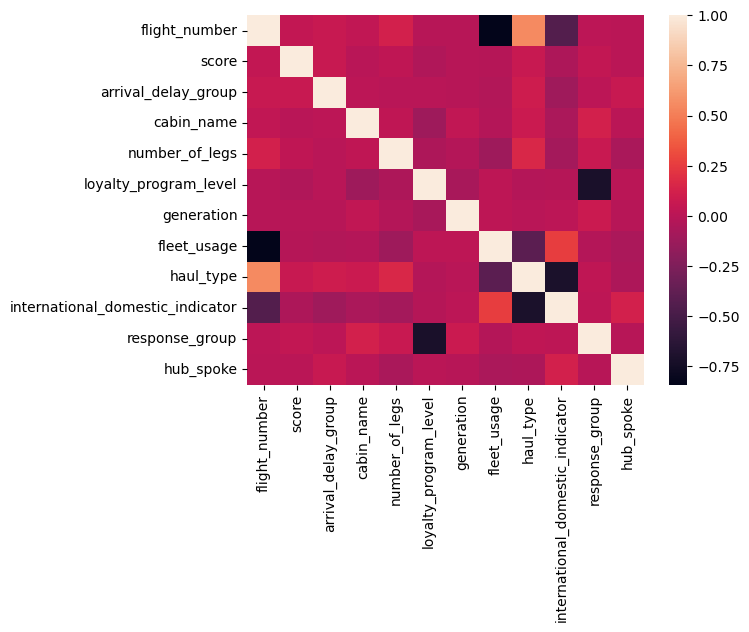

In [14]:
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

### %Inflight Satisfaction = Satisfied Sample/Total Sample*100

In [15]:
satisfied_count=0
for i in df['score']:
    if i>=4:
        satisfied_count+=1
inflight_satisfaction = satisfied_count/len(df['score'])     
print(inflight_satisfaction*100)

36.086400454739234


#### Count of scores vs scores by cabin name

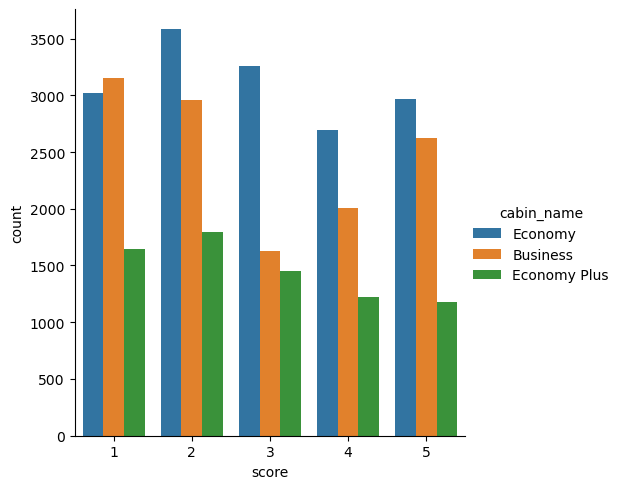

In [72]:
sns.catplot(data=df, x="score", hue='cabin_name', kind="count")

### Merging inflight satisfaction score dataset and preorder dataset

In [17]:
preorder_data.rename(columns={'departure_station_code':'origin_station_code',
                             'arrival_station_code': 'destination_station_code',
                             'scheduled_departure_dtl': 'scheduled_departure_date'}, inplace=True)

In [18]:
join_columns = ['flight_number', 'origin_station_code', 'destination_station_code', 'scheduled_departure_date', 'record_locator']
joined_data = df.merge(preorder_data, on=join_columns, how = 'inner')

joined_data = joined_data.drop_duplicates(keep = 'first')
joined_data

,flight_number,origin_station_code,destination_station_code,record_locator,scheduled_departure_date,question_text,score,satisfaction_type,driver_sub_group1,driver_sub_group2,...,hub_spoke,answer,carrier_code,cabin_code,meal_group,meal_category,meal_short_description,meal_description,is_entree,pre_order_qty
0,486,IAX,INX,PWXXBF,9/1/2022,How satisfied were you with the food & beverag...,5,Satisfied,food & beverage,food and beverage satisfaction,...,hub departure,chicken entrée,UA,J,ENTREES HOT,BEEF/VEAL,Brioche cheeseburger,Brioche burger with bistro sauce,Y,1
1,486,IAX,INX,PWXXBF,9/1/2022,How satisfied were you with the food & beverag...,5,Satisfied,food & beverage,food and beverage satisfaction,...,hub departure,other (specify),UA,J,ENTREES HOT,BEEF/VEAL,Brioche cheeseburger,Brioche burger with bistro sauce,Y,1
2,585,DEX,ORX,J2XXB2,9/1/2022,How satisfied were you with the food & beverag...,1,Dissatisfied,food & beverage,food and beverage satisfaction,...,hub departure,sandwich/burger/wrap,UA,J,ENTREES HOT,BEEF/VEAL,Brioche cheeseburger,Brioche burger with bistro sauce,Y,3
3,1900,IAX,ORX,GEXX5K,9/1/2022,How satisfied were you with the food & beverag...,5,Satisfied,food & beverage,food and beverage satisfaction,...,hub departure,vegetarian entrée,UA,J,ENTREES HOT,VEGETARIAN,Vegetarian chili and polenta cake,NaN,Y,1
4,2488,IAX,MSX,CWXX8W,9/1/2022,How satisfied were you with the food & beverag...,2,Dissatisfied,food & beverage,food and beverage satisfaction,...,hub departure,sandwich/burger/wrap,UA,J,ENTREES HOT,BEEF/VEAL,Brioche cheeseburger,Brioche burger with bistro sauce,Y,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3414,1188,BOX,SFX,CSXXFL,9/30/2022,How satisfied were you with the food & beverag...,1,Dissatisfied,food & beverage,food and beverage satisfaction,...,spoke departure,chicken entrée,UA,J,ENTREES HOT,POULTRY,Za’atar chicken,NaN,Y,1
3415,384,HNX,DEX,A4XX8Q,9/30/2022,How satisfied were you with the food & beverag...,2,Dissatisfied,food & beverage,food and beverage satisfaction,...,spoke departure,No Answer,UA,Y,UNITED CATERER OWNED 88-3F,SNACKS,Tapas,Tapas,N,1
3416,384,HNX,DEX,A4XX8Q,9/30/2022,How satisfied were you with the food & beverag...,2,Dissatisfied,food & beverage,food and beverage satisfaction,...,spoke departure,No Answer,UA,Y,UNITED CATERER OWNED 88-3F,SNACKS,Takeoff,Takeoff,N,1
3417,384,HNX,DEX,A4XX8Q,9/30/2022,How satisfied were you with the food & beverag...,2,Dissatisfied,food & beverage,food and beverage satisfaction,...,spoke departure,No Answer,UA,Y,LIQUOR,LIQUOR,Buffalo Trace,NaN,N,2


In [19]:
dataset = joined_data
dataset = dataset[['flight_number', 'satisfaction_type', 'arrival_delay_group', 'cabin_name', 'entity', 'number_of_legs', 'loyalty_program_level', 'fleet_type_description', 'equipment_type_code', 'generation', 'fleet_usage', 'haul_type', 'international_domestic_indicator', 'response_group', 'hub_spoke', 'answer', 'meal_group', 'meal_category', 'meal_short_description']]

# Applying apriori algorithm to find frequent patterns and association rules

In [20]:
records = []
for i in range(0, 3367):
    records.append([str(dataset.values[i,j]) for j in range(0, 19)])

In [21]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(records).transform(records)
final = pd.DataFrame(te_ary, columns=te.columns_)
final

,1,1000,1003,1005,1007,1009,1012,1014,1017,1019,...,other (specify),premier 1k,premier gold,premier platinum,premier silver,sandwich/burger/wrap,seafood entrée,snack basket selection,spoke departure,vegetarian entrée
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3363,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
3364,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
3365,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False


In [58]:
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(final, min_support=0.2, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# printing the frequent itemset
pd.set_option('display.max_rows', None)
pd.set_option("max_colwidth", None)

frequent_itemsets

,support,itemsets,length
0,0.709534,(1),1
1,0.282744,(2),1
2,0.296703,(37K),1
3,0.215622,(B737-800),1
4,0.321651,(B737-900),1
5,0.227799,(BREAKFAST),1
6,0.564598,(Boomer),1
7,0.865756,(Business),1
8,0.235818,(Delayed),1
9,0.534898,(Dissatisfied),1


In [23]:
#Generating association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))

### Results of apriori algorithm

In [24]:
filtered_rules_dissatisfied = rules[(rules['consequents'].apply(lambda x: 'Dissatisfied' in x))]

filtered_rules_dissatisfied = filtered_rules_dissatisfied[
    (filtered_rules_dissatisfied['antecedents_length'] >= 3) &
    (filtered_rules_dissatisfied['consequents_length'] == 1)
]

filtered_rules_dissatisfied = filtered_rules_dissatisfied.sort_values("lift", ascending=False)

pd.set_option('display.max_rows', None)
filtered_rules_dissatisfied

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
6798,"(Medium, spoke departure, Mainline)",(Dissatisfied),0.348678,0.534898,0.205821,0.590290,1.103556,0.019314,1.135198,3,1
4693,"(Domestic, Boomer, Mainline)",(Dissatisfied),0.507277,0.534898,0.277101,0.546253,1.021229,0.005760,1.025026,3,1
2665,"(member, 1, Mainline)",(Dissatisfied),0.637363,0.534898,0.347787,0.545666,1.020132,0.006864,1.023702,3,1
2584,"(Domestic, 1, Mainline)",(Dissatisfied),0.617464,0.534898,0.336798,0.545455,1.019737,0.006519,1.023225,3,1
2602,"(Domestic, member, 1)",(Dissatisfied),0.557470,0.534898,0.303534,0.544486,1.017926,0.005345,1.021050,3,1
10857,"(Domestic, member, 1, Mainline)",(Dissatisfied),0.557470,0.534898,0.303534,0.544486,1.017926,0.005345,1.021050,4,1
4707,"(Domestic, Medium, Boomer)",(Dissatisfied),0.487971,0.534898,0.265221,0.543518,1.016116,0.004207,1.018884,3,1
15121,"(Domestic, Medium, Boomer, Mainline)",(Dissatisfied),0.487971,0.534898,0.265221,0.543518,1.016116,0.004207,1.018884,4,1
2593,"(Domestic, Medium, 1)",(Dissatisfied),0.596377,0.534898,0.322839,0.541335,1.012034,0.003839,1.014034,3,1
10840,"(Domestic, Medium, 1, Mainline)",(Dissatisfied),0.596377,0.534898,0.322839,0.541335,1.012034,0.003839,1.014034,4,1


In [25]:
filtered_rules_satisfied = rules[(rules['consequents'].apply(lambda x: 'Satisfied' in x))]

filtered_rules_satisfied = filtered_rules_satisfied[
    (filtered_rules_satisfied['antecedents_length'] >= 3) &
    (filtered_rules_satisfied['consequents_length'] == 1)
]

filtered_rules_satisfied = filtered_rules_satisfied.sort_values("lift", ascending=False)

pd.set_option('display.max_rows', None)
filtered_rules_satisfied

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
21466,"(Medium, member, hub departure, ENTREES HOT)",(Satisfied),0.428571,0.465102,0.231066,0.539155,1.159217,0.031737,1.160687,4,1
38898,"(member, ENTREES HOT, hub departure, Medium, M...",(Satisfied),0.428571,0.465102,0.231066,0.539155,1.159217,0.031737,1.160687,5,1
51082,"(Domestic, member, ENTREES HOT, hub departure,...",(Satisfied),0.385209,0.465102,0.207603,0.538936,1.158747,0.028441,1.160137,6,1
38315,"(Domestic, member, ENTREES HOT, hub departure,...",(Satisfied),0.385209,0.465102,0.207603,0.538936,1.158747,0.028441,1.160137,5,1
20437,"(Domestic, member, hub departure, ENTREES HOT)",(Satisfied),0.392931,0.465102,0.211761,0.538927,1.158727,0.029008,1.160114,4,1
38253,"(Domestic, member, ENTREES HOT, hub departure,...",(Satisfied),0.392931,0.465102,0.211761,0.538927,1.158727,0.029008,1.160114,5,1
36976,"(member, ENTREES HOT, hub departure, Business,...",(Satisfied),0.428274,0.465102,0.230769,0.538835,1.158530,0.031578,1.159883,5,1
50639,"(member, ENTREES HOT, hub departure, Business,...",(Satisfied),0.428274,0.465102,0.230769,0.538835,1.158530,0.031578,1.159883,6,1
55287,"(Domestic, member, ENTREES HOT, hub departure,...",(Satisfied),0.384912,0.465102,0.207306,0.538580,1.157982,0.028283,1.159243,7,1
49686,"(Domestic, member, ENTREES HOT, hub departure,...",(Satisfied),0.384912,0.465102,0.207306,0.538580,1.157982,0.028283,1.159243,6,1


### Satisfaction Rate by Response Group

                Satisfied Count  Total Count   Rate
response_group                                     
NBK                           1            3  33.33
member                     9143        25794  35.45
non-member                 3553         9388  37.85


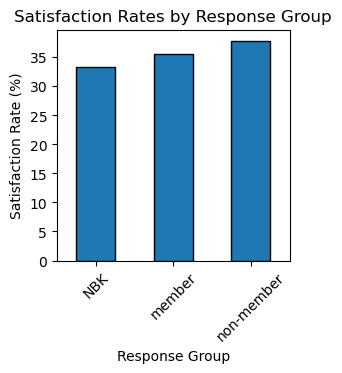

In [26]:
satisfied_count_by_response_group = df[df['score'] >= 4].groupby('response_group')['score'].count()
total_count_by_response_group = df.groupby('response_group')['score'].count()
satisfaction_rate_by_response_group = (satisfied_count_by_response_group / total_count_by_response_group) * 100

rate_df = satisfaction_rate_by_response_group.to_frame(name='Rate').round(2)
total_df = total_count_by_response_group.to_frame(name='Total Count')
satisfied_df = satisfied_count_by_response_group.to_frame(name='Satisfied Count')

result_df = pd.concat([satisfied_df, total_df, rate_df], axis=1)
print(result_df)


plt.figure(figsize=(3, 3))
satisfaction_rate_by_response_group.plot(kind='bar', edgecolor='black')

plt.xlabel('Response Group')
plt.ylabel('Satisfaction Rate (%)')
plt.title('Satisfaction Rates by Response Group')
plt.xticks(rotation=45)
plt.show()

#### Most ordered food by response group

In [27]:
preorder_by_response_group = joined_data.groupby(['response_group', 'meal_short_description'])['pre_order_qty'].sum()
most_ordered_by_response_group = preorder_by_response_group.groupby('response_group').idxmax()

print("Most Ordered Food Items by Response Group:")
for response_group, meal_description in most_ordered_by_response_group.items():
    print(f"{response_group} Group: {meal_description[1]}")


Most Ordered Food Items by Response Group:
member Group: Za’atar chicken
non-member Group: Brioche cheeseburger


In [28]:
preorder_by_response_group = joined_data.groupby(['response_group', 'meal_category'])['pre_order_qty'].sum()
most_ordered_by_response_group = preorder_by_response_group.groupby('response_group').idxmax()

print("Most Ordered Food Items by Response Group:")
for response_group, meal_category in most_ordered_by_response_group.items():
    print(f"{response_group} Group: {meal_category[1]}")


Most Ordered Food Items by Response Group:
member Group: POULTRY
non-member Group: BREAKFAST


### Satisfaction Rate by Hub Spoke Departure

Satisfaction Count by Hub Spoke:
hub departure: 6520
spoke departure: 6177


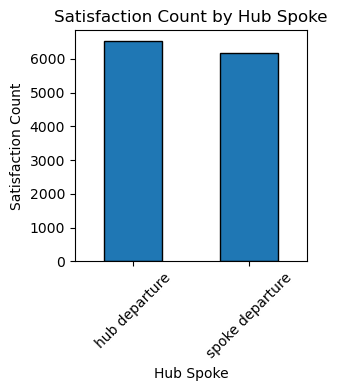

In [29]:
satisfied_count_by_hub_spoke = df[df['score'] >= 4].groupby('hub_spoke')['score'].count()

print("Satisfaction Count by Hub Spoke:")
for group, count in satisfied_count_by_hub_spoke.items():
    print(f"{group}: {count}")
    
plt.figure(figsize=(3, 3))
satisfied_count_by_hub_spoke.plot(kind='bar', edgecolor='black')

plt.xlabel('Hub Spoke')
plt.ylabel('Satisfaction Count')
plt.title('Satisfaction Count by Hub Spoke')
plt.xticks(rotation=45)
plt.show()

#### Most ordered food by hub spoke


In [66]:
preorder_by_response_group = joined_data.groupby(['hub_spoke', 'meal_category'])['pre_order_qty'].sum()
most_ordered_by_response_group = preorder_by_response_group.groupby('hub_spoke').idxmax()

print("Most Ordered Food Items by Hub_Spoke Departure:")
for response_group, meal_description in most_ordered_by_response_group.items():
    print(f"{response_group} Group: {meal_description[1]}")


Most Ordered Food Items by Hub_Spoke Departure:
hub departure Group: BREAKFAST
spoke departure Group: POULTRY


### Satisfaction Count by Meal Group

                            Satisfied Count  Total Count
meal_group                                              
ALCOHOL BEVERAGES                      14.0           35
BEER                                   14.0           27
ENTREES COLD                            6.0           19
ENTREES HOT                          1255.0         2525
LIQUOR                                 19.0           50
UNITED CATERER OWNED 88-3F            145.0          377
SANDWICHES                              NaN            1


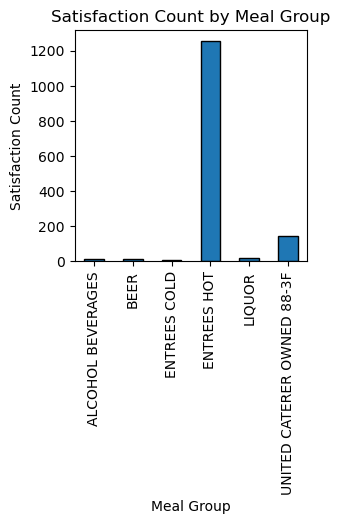

In [31]:
satisfied_count_by_meal_group = joined_data[joined_data['score'] >= 4].groupby('meal_group')['score'].count()
total_count_by_meal_group = joined_data.groupby('meal_group')['score'].count()

total_df = total_count_by_meal_group.to_frame(name='Total Count')
satisfied_df = satisfied_count_by_meal_group.to_frame(name='Satisfied Count')

result_df = pd.concat([satisfied_df, total_df], axis=1)
print(result_df)
    
plt.figure(figsize=(3, 3))
satisfied_count_by_meal_group.plot(kind='bar', edgecolor='black')

plt.xlabel('Meal Group')
plt.ylabel('Satisfaction Count')
plt.title('Satisfaction Count by Meal Group')
plt.show()

#### Most Ordered Food Items by Meal Group:


In [32]:
preorder_by_meal_group = joined_data.groupby(['meal_group' ,'meal_short_description'])['pre_order_qty'].sum()
most_ordered_by_meal_group = preorder_by_meal_group.groupby('meal_group').idxmax()

print("Most Ordered Food Items by Meal Group:")
for meal_group, meal_description in most_ordered_by_meal_group.items():
    print(f"{meal_group} Group: {meal_description[1]}")


Most Ordered Food Items by Meal Group:
ALCOHOL BEVERAGES Group: Red Wine
BEER Group: Lagunitas Hazy Wonder IPA
ENTREES COLD Group: Classic selection cheese tray
ENTREES HOT Group: Za’atar chicken
LIQUOR Group: Buffalo Trace
SANDWICHES Group: Scrambled egg sandwich
UNITED CATERER OWNED 88-3F Group: Takeoff


### Satisfaction Count by Number of Legs in a Trip

                Satisfied Count  Total Count   Rate
number_of_legs                                     
1                          8274        23271  35.55
2                          4233        11423  37.06
3                           190          491  38.70


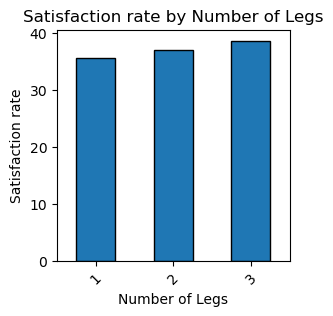

In [33]:
satisfied_count_by_number_of_legs = df[df['score'] >= 4].groupby('number_of_legs')['score'].count()
total_count_by_number_of_legs = df.groupby('number_of_legs')['score'].count()
satisfaction_rate_by_number_of_legs = (satisfied_count_by_number_of_legs / total_count_by_number_of_legs) * 100

rate_df = satisfaction_rate_by_number_of_legs.to_frame(name='Rate').round(2)
total_df = total_count_by_number_of_legs.to_frame(name='Total Count')
satisfied_df = satisfied_count_by_number_of_legs.to_frame(name='Satisfied Count')

result_df = pd.concat([satisfied_df, total_df, rate_df], axis=1)
print(result_df)
    
plt.figure(figsize=(3, 3))
satisfaction_rate_by_number_of_legs.plot(kind='bar', edgecolor='black')

plt.xlabel('Number of Legs')
plt.ylabel('Satisfaction rate')
plt.title('Satisfaction rate by Number of Legs')
plt.xticks(rotation=45)
plt.show()

#### Most Ordered Food Items by Number of Legs


In [34]:
preorder_by_number_of_legs = joined_data.groupby(['number_of_legs' ,'meal_short_description'])['pre_order_qty'].sum()
most_ordered_by_number_of_legs = preorder_by_number_of_legs.groupby('number_of_legs').idxmax()

print("Most Ordered Food Items by Number of Legs:")
for number_of_legs, meal_description in most_ordered_by_number_of_legs.items():
    print(f"{number_of_legs} Leg: {meal_description[1]}")


Most Ordered Food Items by Number of Legs:
1 Leg: Za’atar chicken
2 Leg: Brioche cheeseburger
3 Leg: Za’atar chicken


### Satisfaction Count by Generation

            Satisfied Count  Total Count   Rate
generation                                     
Boomer               6038.0        16521  36.55
Gen X                3960.0        11119  35.61
Gen Z                 328.0          825  39.76
Millennial           1739.0         4990  34.85
NBK                     1.0            3  33.33
Silent                631.0         1725  36.58
Greatest                NaN            2    NaN


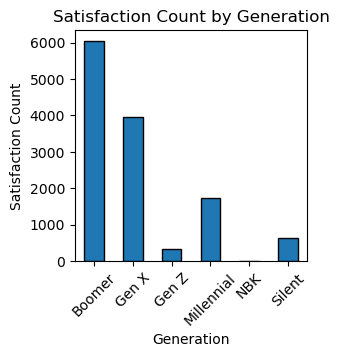

In [35]:
satisfied_count_by_generation = df[df['score'] >= 4].groupby('generation')['score'].count()
total_count_by_generation = df.groupby('generation')['score'].count()
satisfaction_rate_by_generation = (satisfied_count_by_generation / total_count_by_generation) * 100

rate_df = satisfaction_rate_by_generation.to_frame(name='Rate').round(2)
total_df = total_count_by_generation.to_frame(name='Total Count')
satisfied_df = satisfied_count_by_generation.to_frame(name='Satisfied Count')

result_df = pd.concat([satisfied_df, total_df, rate_df], axis=1)
print(result_df)
    
plt.figure(figsize=(3, 3))
satisfied_count_by_generation.plot(kind='bar', edgecolor='black')

plt.xlabel('Generation')
plt.ylabel('Satisfaction Count')
plt.title('Satisfaction Count by Generation')
plt.xticks(rotation=45)
plt.show()

#### Most Ordered Food Items by Generation


In [36]:
preorder_by_generation = joined_data.groupby(['generation' ,'meal_short_description'])['pre_order_qty'].sum()
most_ordered_by_generation = preorder_by_generation.groupby('generation').idxmax()

print("Most Ordered Food Items by Generation:")
for generation, meal_description in most_ordered_by_generation.items():
    print(f"{generation} : {meal_description[1]}")


Most Ordered Food Items by Generation:
Boomer : Za’atar chicken
Gen X : Za’atar chicken
Gen Z : Brioche cheeseburger
Millennial : Za’atar chicken
Silent : Brioche cheeseburger


### Satisfaction Count by Haul Type

           Satisfied Count  Total Count   Rate
haul_type                                     
Long                  3323        10155  32.72
Medium                8075        21162  38.16
Short                 1299         3868  33.58


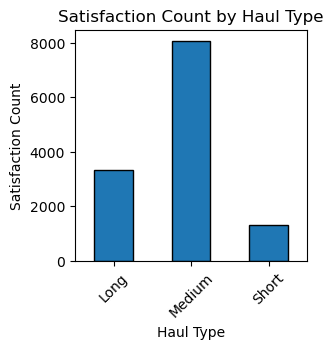

In [37]:
satisfied_count_by_haul_type = df[df['score'] >= 4].groupby('haul_type')['score'].count()
total_count_by_haul_type = df.groupby('haul_type')['score'].count()
satisfaction_rate_by_haul_type = (satisfied_count_by_haul_type / total_count_by_haul_type) * 100

rate_df = satisfaction_rate_by_haul_type.to_frame(name='Rate').round(2)
total_df = total_count_by_haul_type.to_frame(name='Total Count')
satisfied_df = satisfied_count_by_haul_type.to_frame(name='Satisfied Count')

result_df = pd.concat([satisfied_df, total_df, rate_df], axis=1)
print(result_df)
    
plt.figure(figsize=(3, 3))
satisfied_count_by_haul_type.plot(kind='bar', edgecolor='black')

plt.xlabel('Haul Type')
plt.ylabel('Satisfaction Count')
plt.title('Satisfaction Count by Haul Type')
plt.xticks(rotation=45)
plt.show()

#### Most Ordered Food Items by Haul Type:


In [38]:
preorder_by_haul_type = joined_data.groupby(['haul_type' ,'meal_short_description'])['pre_order_qty'].sum()
most_ordered_by_haul_type = preorder_by_haul_type.groupby('haul_type').idxmax()

print("Most Ordered Food Items by Haul Type:")
for haul_type, meal_description in most_ordered_by_haul_type.items():
    print(f"{haul_type} : {meal_description[1]}")


Most Ordered Food Items by Haul Type:
Long : Chicken katsu
Medium : Brioche cheeseburger


### Satisfaction Count by Fleet Usage

             Satisfied Count  Total Count   Rate
fleet_usage                                     
Express                 1631         4516  36.12
Mainline               11066        30669  36.08


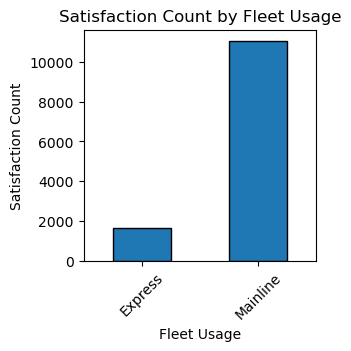

In [39]:
satisfied_count_by_fleet_usage = df[df['score'] >= 4].groupby('fleet_usage')['score'].count()
total_count_by_fleet_usage = df.groupby('fleet_usage')['score'].count()
satisfaction_rate_by_fleet_usage = (satisfied_count_by_fleet_usage / total_count_by_fleet_usage) * 100

rate_df = satisfaction_rate_by_fleet_usage.to_frame(name='Rate').round(2)
total_df = total_count_by_fleet_usage.to_frame(name='Total Count')
satisfied_df = satisfied_count_by_fleet_usage.to_frame(name='Satisfied Count')

result_df = pd.concat([satisfied_df, total_df, rate_df], axis=1)
print(result_df)
    
plt.figure(figsize=(3, 3))
satisfied_count_by_fleet_usage.plot(kind='bar', edgecolor='black')

plt.xlabel('Fleet Usage')
plt.ylabel('Satisfaction Count')
plt.title('Satisfaction Count by Fleet Usage')
plt.xticks(rotation=45)
plt.show()

#### Most Ordered Food Items by fleet_usage:


In [40]:
preorder_by_fleet_usage = joined_data.groupby(['fleet_usage' ,'meal_short_description'])['pre_order_qty'].sum()
most_ordered_by_fleet_usage = preorder_by_fleet_usage.groupby('fleet_usage').idxmax()

print("Most Ordered Food Items by fleet_usage:")
for fleet_usage, meal_description in most_ordered_by_fleet_usage.items():
    print(f"{fleet_usage} : {meal_description[1]}")


Most Ordered Food Items by fleet_usage:
Mainline : Za’atar chicken


### Satisfaction Count by Cabin Name

              Satisfied Count  Total Count
cabin_name                                
Business                 4635        12369
Economy                  5666        15531
Economy Plus             2396         7285


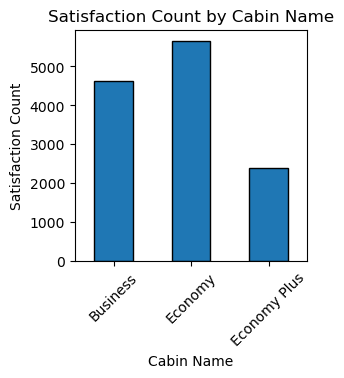

In [41]:
satisfied_count_by_cabin_name = df[df['score'] >= 4].groupby('cabin_name')['score'].count()
total_count_by_cabin_name = df.groupby('cabin_name')['score'].count()

total_df = total_count_by_cabin_name.to_frame(name='Total Count')
satisfied_df = satisfied_count_by_cabin_name.to_frame(name='Satisfied Count')

result_df = pd.concat([satisfied_df, total_df], axis=1)
print(result_df)
    
plt.figure(figsize=(3, 3))
satisfied_count_by_cabin_name.plot(kind='bar', edgecolor='black')

plt.xlabel('Cabin Name')
plt.ylabel('Satisfaction Count')
plt.title('Satisfaction Count by Cabin Name')
plt.xticks(rotation=45)
plt.show()

#### Most Ordered Food Items by Cabin_name:


In [42]:
preorder_by_cabin_name = joined_data.groupby(['cabin_name' ,'meal_short_description'])['pre_order_qty'].sum()
most_ordered_by_cabin_name = preorder_by_cabin_name.groupby('cabin_name').idxmax()

print("Most Ordered Food Items by Cabin_name:")
for cabin_name, meal_description in most_ordered_by_cabin_name.items():
    print(f"{cabin_name} : {meal_description[1]}")


Most Ordered Food Items by Cabin_name:
Business : Za’atar chicken
Economy : Takeoff
Economy Plus : Takeoff


### Satisfaction Rate by Food

                        Satisfied Count  Total Count   Rate
answer                                                     
snack basket selection              120          241  49.79
beef entrée                         413         1008  40.97
sandwich/burger/wrap                297          766  38.77
other (specify)                    1299         3358  38.68
seafood entrée                      174          457  38.07
vegetarian entrée                   843         2255  37.38
chicken entrée                     2066         5532  37.35
No Answer                          7458        21505  34.68


<Figure size 200x200 with 0 Axes>

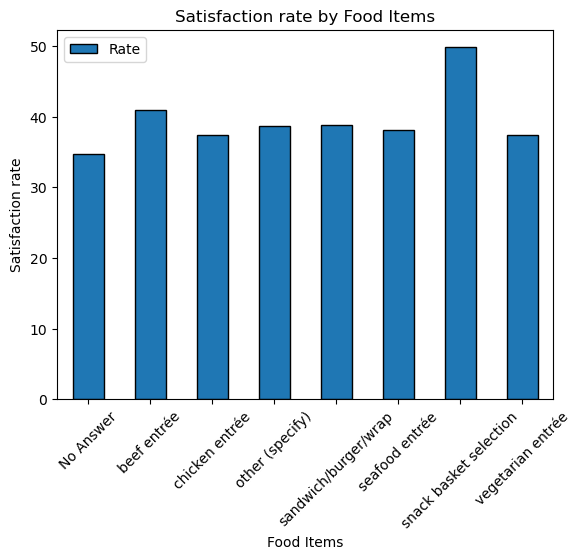

In [63]:
satisfied_count_by_answer = df[df['score'] >= 4].groupby('answer')['score'].count()
total_count_by_answer = df.groupby('answer')['score'].count()
satisfaction_rate_by_answer = (satisfied_count_by_answer / total_count_by_answer) * 100


rate_df = satisfaction_rate_by_answer.to_frame(name='Rate').round(2)
total_df = total_count_by_answer.to_frame(name='Total Count')
satisfied_df = satisfied_count_by_answer.to_frame(name='Satisfied Count')

rate_df = rate_df[~rate_df.index.isin(['1', '2', '3', '4', '5'])]


result_df = pd.concat([satisfied_df, total_df, rate_df], axis=1)
result_df = result_df[~result_df.index.isin(['1', '2', '3', '4', '5'])]


print(result_df.sort_values("Rate", ascending=False))
    
plt.figure(figsize=(2, 2))
rate_df.plot(kind='bar', edgecolor='black')

plt.xlabel('Food Items')
plt.ylabel('Satisfaction rate')
plt.title('Satisfaction rate by Food Items')
plt.xticks(rotation=45)
plt.show()

### Satisfaction Count by Meal Category

                    Satisfied Count  Total Count    Rate
meal_category                                           
BEEF/VEAL                     210.0          462   45.45
BEER                           14.0           27   51.85
BREAKFAST                     485.0          767   63.23
CHEESE                          6.0           17   35.29
DINNER                          1.0            1  100.00
GENERIC INT WINE A             14.0           35   40.00
LIQUOR                         19.0           50   38.00
PASTA                           8.0           25   32.00
PORK                            2.0            3   66.67
POULTRY                       291.0          733   39.70
SEAFOOD                         7.0           18   38.89
SNACKS                        145.0          377   38.46
VEGETARIAN                    251.0          516   48.64
SANDWICH                        NaN            1     NaN
VARIETY                         NaN            2     NaN


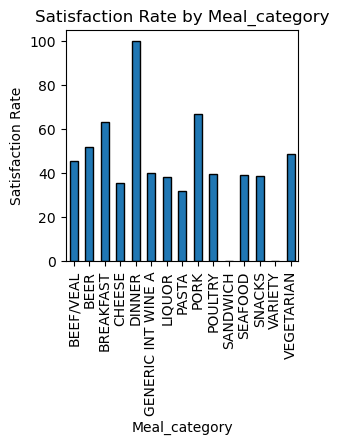

In [64]:
satisfied_count_by_meal_category = joined_data[joined_data['score'] >= 4].groupby('meal_category')['score'].count()
total_count_by_meal_category = joined_data.groupby('meal_category')['score'].count()
satisfaction_rate_by_meal_category = (satisfied_count_by_meal_category / total_count_by_meal_category) * 100

rate_df = satisfaction_rate_by_meal_category.to_frame(name='Rate').round(2)
total_df = total_count_by_meal_category.to_frame(name='Total Count')
satisfied_df = satisfied_count_by_meal_category.to_frame(name='Satisfied Count')

result_df = pd.concat([satisfied_df, total_df, rate_df], axis=1)
print(result_df)
    
plt.figure(figsize=(3, 3))
satisfaction_rate_by_meal_category.plot(kind='bar', edgecolor='black')

plt.xlabel('Meal_category')
plt.ylabel('Satisfaction Rate')
plt.title('Satisfaction Rate by Meal_category')
plt.show()

## Top Preorder meals by cabin name

In [45]:
top_preordered_meals = joined_data.groupby(['cabin_name', 'meal_short_description'])['pre_order_qty'].sum().sort_values(ascending=False).head(20)
top_preordered_meals

cabin_name    meal_short_description                                 
Business      Za’atar chicken                                            730
              Brioche cheeseburger                                       728
              Scrambled eggs                                             420
              Impossible™ Meatball Bowl                                  365
              Belgium waffle                                             264
              Za'atar chicken with spinach, roasted peppers, and orzo    224
              Tomato and kale baked egg                                  176
              Vegetarian chili and polenta cake                          172
              Gingerbread French Toast                                   136
              Mediterranean Falafel Bowl                                 129
              Horchata steel cut oatmeal                                 100
Economy Plus  Takeoff                                                     97
Busine

## Joining inflight satisfaction dataset with inventory dataset

In [46]:
inventory_data.rename(columns={'departure_station_code':'origin_station_code',
                             'arrival_station_code': 'destination_station_code',
                             'scheduled_departure_dtl': 'scheduled_departure_date'}, inplace=True)
join_columns = ['flight_number', 'origin_station_code', 'destination_station_code', 'scheduled_departure_date']
joined_data2 = df.merge(inventory_data, on=join_columns, how = 'inner')

#### Average utilization rate grouped by number of legs

In [47]:
joined_data2 = joined_data2[joined_data2['planned_entree_count'] > 0]
joined_data2['utilization_rate'] = joined_data2['consumed_entree_count'] / joined_data2['planned_entree_count']


average_utilization_by_leg = joined_data2.groupby('number_of_legs')['utilization_rate'].mean()

for leg, utilization in average_utilization_by_leg.items():
    print(f"Average Inventory Utilization Rate for {leg} Leg trip : {utilization * 100:.2f}%")


Average Inventory Utilization Rate for 1 Leg trip : 39.52%
Average Inventory Utilization Rate for 2 Leg trip : 37.28%
Average Inventory Utilization Rate for 3 Leg trip : 36.71%


## Using comments/feedbacks(verbatim_text) to understand major themes related to F&B that passengers are complaining about

In [48]:
sia = SentimentIntensityAnalyzer()

def preprocess_text(text):
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word.isalnum()]
    words = [word for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

comments_data['processed_text'] = comments_data['verbatim_text'].apply(preprocess_text)

comments_data['sentiment_score'] = comments_data['processed_text'].apply(lambda text: sia.polarity_scores(text)['compound'])

negative_comments = comments_data[comments_data['sentiment_score'] < 0]

vectorizer = CountVectorizer(max_features=1000, stop_words='english')
dtm = vectorizer.fit_transform(negative_comments['processed_text'])

num_topics = 10  
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)

for i, topic in enumerate(lda.components_):
    top_words = [vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]]
    print(f"\nTopic {i + 1}: {' | '.join(top_words)}")



Topic 1: meal | options | served | flights | poor | class | quality | flight | wine | food

Topic 2: need | hour | beverages | getting | class | breakfast | attendants | service | miss | flight

Topic 3: problem | flight | water | difficult | plane | offered | selection | small | limited | snacks

Topic 4: cheese | offer | entree | snack | know | chicken | offered | served | meal | flight

Topic 5: meal | cut | food | flight | bag | snack | hard | tough | chicken | pretzels

Topic 6: cheese | better | cookie | selection | poor | snack | options | nuts | food | breakfast

Topic 7: limited | chicken | order | time | meals | options | beverage | meal | food | flight

Topic 8: mary | low | disappointing | drink | salad | beverage | available | options | flight | option

Topic 9: disappointing | snack | choices | bread | business | food | flight | offered | meal | class

Topic 10: water | taste | flight | snack | tea | awful | tasted | terrible | coffee | bad


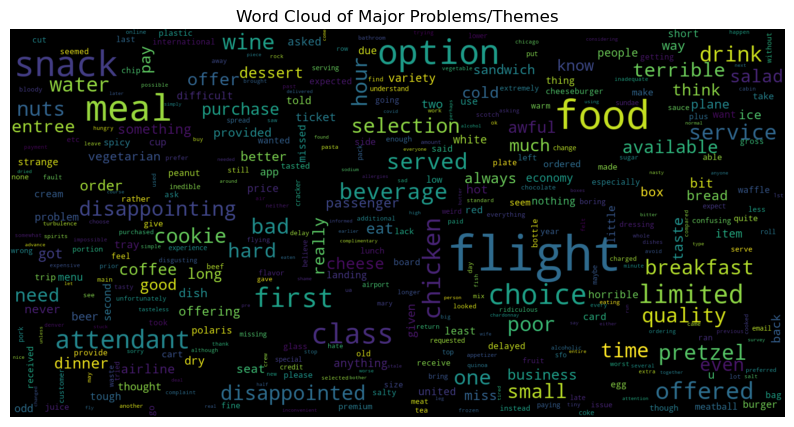

In [70]:
all_words = " ".join([tweet for tweet in comments_data['processed_text'][comments_data['sentiment_score']<0]])

wordcloud = WordCloud(max_words = 400, width=1600, height=800, collocations = False, max_font_size=100).generate(all_words)

plt.figure(figsize=(10, 60))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Major Problems/Themes')
plt.show()